# The FitzHugh-Nagumo Model

A classical model of neural excitability capturing the essence of action potential generation.

## Learning Objectives

By the end of this tutorial, you will be able to:

- Understand the FitzHugh-Nagumo equations as a reduction of Hodgkin-Huxley
- Distinguish between excitable and oscillatory parameter regimes
- Analyze nullclines and fixed points in phase space
- Build a brain network with FHN nodes and diffusive coupling
- Compute functional connectivity from simulated dynamics

## Background / Theory

### From Hodgkin-Huxley to FitzHugh-Nagumo

The **Hodgkin-Huxley** model describes action potentials with 4 differential equations. Richard FitzHugh (1961) and Jin-ichi Nagumo (1962) independently reduced this to a 2D system that captures the essential dynamics:

- **Fast variable** $V$: membrane potential (activator)
- **Slow variable** $w$: recovery (inhibitor)

### Mathematical Formulation

BrainMass implements the polynomial form:

$$
\begin{aligned}
\dot{V} &= -\alpha V^3 + \beta V^2 + \gamma V - w + I_{ext}(t) \\
\tau \dot{w} &= V - \delta - \epsilon w
\end{aligned}
$$

### Parameters

| Parameter | Default | Role |
|-----------|---------|------|
| $\alpha$ | 3.0 | Cubic nonlinearity (N-shaped nullcline) |
| $\beta$ | 4.0 | Quadratic term |
| $\gamma$ | -1.5 | Linear restoring force |
| $\delta$ | 0.0 | w-nullcline offset |
| $\epsilon$ | 0.5 | Recovery coupling |
| $\tau$ | 20 ms | Recovery time constant |

### Key Concepts

**Nullclines:**
- V-nullcline: $w = -\alpha V^3 + \beta V^2 + \gamma V + I_{ext}$ (cubic)
- w-nullcline: $V = \delta + \epsilon w$ (linear)

**Dynamics depend on intersection:**
- Intersection on middle branch → **excitable** (responds to perturbation)
- Intersection on unstable branch → **oscillatory** (spontaneous activity)

## Implementation

### Step 1: Setup and Imports

In [1]:
import brainmass
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

# Set simulation time step
brainstate.environ.set(dt=0.1 * u.ms)

### Step 2: Single Node Simulation

Create an FHN oscillator with noise:

In [2]:
# Create FHN model with default parameters
node = brainmass.FitzHughNagumoStep(
    1,  # single node
    alpha=3.0,
    beta=4.0,
    gamma=-1.5,
    delta=0.0,
    epsilon=0.5,
    tau=20.0 * u.ms,
    noise_V=brainmass.OUProcess(1, sigma=0.01),
    noise_w=brainmass.OUProcess(1, sigma=0.01),
)

# Initialize states
node.init_all_states()

print(f"tau = {node.tau.value()}")
print(f"epsilon = {node.epsilon.value()}")

tau = 20.0 * msecond
epsilon = 0.5


In [3]:
# Simulation step function
def step_run(i):
    node.update()
    return node.V.value, node.w.value


# Run simulation (1000 ms)
indices = np.arange(10000)
V_trace, w_trace = brainstate.transform.for_loop(step_run, indices)

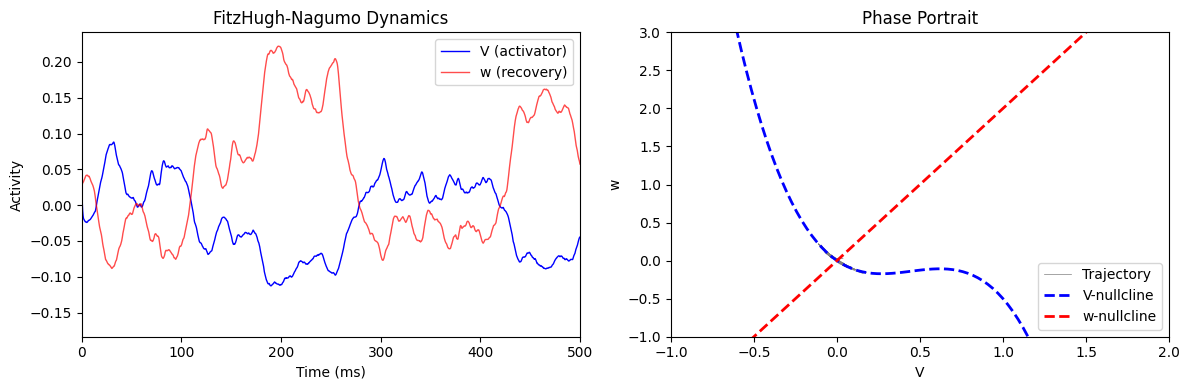

In [4]:
times = indices * brainstate.environ.get_dt()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Time series
axes[0].plot(times, V_trace[:, 0], 'b-', label='V (activator)', linewidth=1)
axes[0].plot(times, w_trace[:, 0], 'r-', label='w (recovery)', linewidth=1, alpha=0.7)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Activity')
axes[0].set_title('FitzHugh-Nagumo Dynamics')
axes[0].legend()
axes[0].set_xlim([0, 500])

# Phase portrait with nullclines
V_range = np.linspace(-1, 2, 100)
alpha, beta, gamma = 3.0, 4.0, -1.5
V_nullcline = -alpha * V_range ** 3 + beta * V_range ** 2 + gamma * V_range
w_nullcline = V_range / 0.5  # V = delta + epsilon*w -> w = V/epsilon

axes[1].plot(V_trace[:, 0], w_trace[:, 0], 'k-', linewidth=0.5, alpha=0.5, label='Trajectory')
axes[1].plot(V_range, V_nullcline, 'b--', linewidth=2, label='V-nullcline')
axes[1].plot(V_range, w_nullcline, 'r--', linewidth=2, label='w-nullcline')
axes[1].set_xlabel('V')
axes[1].set_ylabel('w')
axes[1].set_title('Phase Portrait')
axes[1].legend()
axes[1].set_xlim([-1, 2])
axes[1].set_ylim([-1, 3])

plt.tight_layout()
plt.show()

### Step 3: Excitable vs Oscillatory Regimes

External input shifts the V-nullcline, changing the system's behavior:

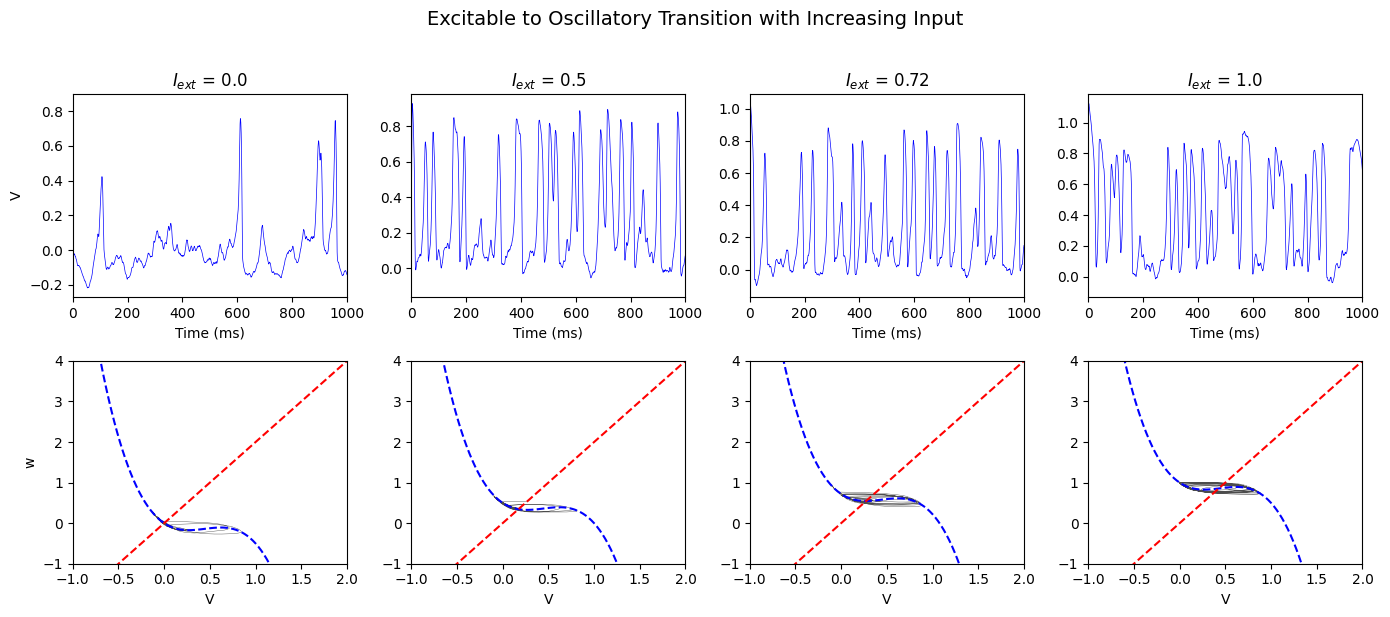

In [5]:
input_values = [0.0, 0.5, 0.72, 1.0]

fig, axes = plt.subplots(2, len(input_values), figsize=(14, 6))

for idx, I_ext in enumerate(input_values):
    # Create model
    model = brainmass.FitzHughNagumoStep(
        1,
        noise_V=brainmass.OUProcess(1, sigma=0.02),
        noise_w=brainmass.OUProcess(1, sigma=0.02),
    )
    model.init_all_states()


    # Simulate with constant input
    def step(i):
        model.update(V_inp=I_ext)
        return model.V.value, model.w.value


    V, w = brainstate.transform.for_loop(step, np.arange(20000))

    # Time series (top)
    axes[0, idx].plot(np.arange(len(V)) * 0.1, V[:, 0], 'b-', linewidth=0.5)
    axes[0, idx].set_title(f'$I_{{ext}}$ = {I_ext}')
    axes[0, idx].set_xlabel('Time (ms)')
    if idx == 0:
        axes[0, idx].set_ylabel('V')
    axes[0, idx].set_xlim([0, 1000])

    # Phase portrait (bottom)
    axes[1, idx].plot(V[-5000:, 0], w[-5000:, 0], 'k-', linewidth=0.3, alpha=0.7)
    # V-nullcline shifts with input
    V_null = -3 * V_range ** 3 + 4 * V_range ** 2 - 1.5 * V_range + I_ext
    axes[1, idx].plot(V_range, V_null, 'b--', linewidth=1.5)
    axes[1, idx].plot(V_range, V_range / 0.5, 'r--', linewidth=1.5)
    axes[1, idx].set_xlabel('V')
    if idx == 0:
        axes[1, idx].set_ylabel('w')
    axes[1, idx].set_xlim([-1, 2])
    axes[1, idx].set_ylim([-1, 4])

plt.suptitle('Excitable to Oscillatory Transition with Increasing Input', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Step 4: Bifurcation Diagram

Scan external input to find the oscillation threshold:

In [12]:
# Scan input values
exc_inputs = np.linspace(0, 2, 500)

# Create nodes for each input level
nodes = brainmass.FitzHughNagumoStep(exc_inputs.size)
nodes.init_all_states()


def step_run(i):
    return nodes.update(V_inp=exc_inputs)


# Simulate
indices = np.arange(10000)
V_activity = brainstate.transform.for_loop(step_run, indices)
V_activity = V_activity[1000:]  # Discard transient

# Get max/min
max_V = V_activity.max(axis=0)
min_V = V_activity.min(axis=0)

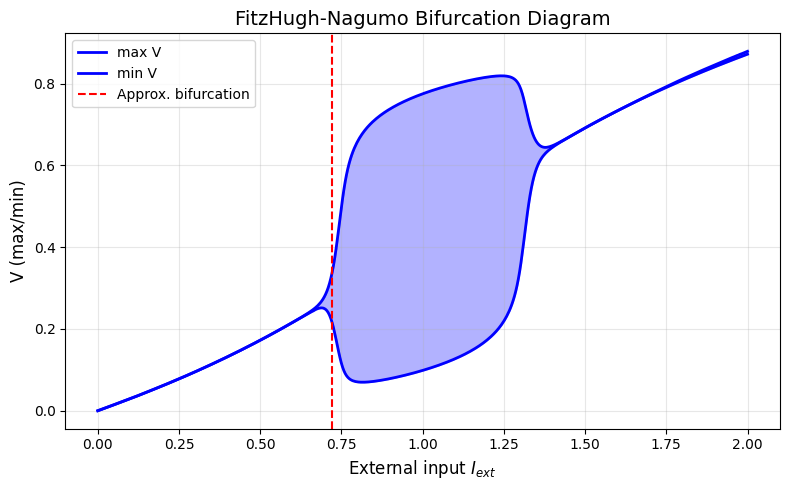

In [13]:
plt.figure(figsize=(8, 5))
plt.fill_between(exc_inputs, min_V, max_V, alpha=0.3, color='blue')
plt.plot(exc_inputs, max_V, 'b-', lw=2, label='max V')
plt.plot(exc_inputs, min_V, 'b-', lw=2, label='min V')
plt.axvline(0.72, color='red', linestyle='--', label='Approx. bifurcation')

plt.xlabel('External input $I_{ext}$', fontsize=12)
plt.ylabel('V (max/min)', fontsize=12)
plt.title('FitzHugh-Nagumo Bifurcation Diagram', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 5: Brain Network with FHN Nodes


For $N$ nodes with states $(V_i, w_i)$, a common diffusive coupling on $V$ is:

$$
\begin{aligned}
\dot V_i &= f(V_i, w_i) + K \sum_j W_{ij}(V_j - V_i) + I_i^V(t), \
\tau \dot w_i &= g(V_i, w_i) + I_i^w(t),
\end{aligned}
$$

Here $W$ is the connectivity and $K$ a global gain. In BrainMass, you can assemble this using `brainmass.diffusive_coupling` with prefetches for the $V$ variables, or the module `DiffusiveCoupling`.

Relation to phase models: near a stable limit cycle (if parameters permit), the dynamics can be approximated by phase-only coupling (Kuramoto-type).


Build a whole-brain network using FHN nodes with diffusive coupling:

In [8]:
# Load Human Connectome Project data
import os.path
import kagglehub

path = kagglehub.dataset_download("oujago/hcp-gw-data-samples")
data = braintools.file.msgpack_load(os.path.join(path, "hcp-data-sample.msgpack"))

print(f"Connectome: {data['Cmat'].shape[0]} brain regions")

Loading checkpoint from D:\Data\kagglehub\datasets\oujago\hcp-gw-data-samples\versions\1\hcp-data-sample.msgpack
Connectome: 80 brain regions


In [9]:
class FHNNetwork(brainstate.nn.Module):
    """Brain network with FitzHugh-Nagumo nodes."""

    def __init__(self, signal_speed=2.0, coupling_k=1.0, input_drive=0.72):
        super().__init__()

        # Connectivity
        conn_weight = data['Cmat'].copy()
        np.fill_diagonal(conn_weight, 0)

        # Delays from distance
        delay_time = data['Dmat'].copy() / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.arange(conn_weight.shape[1])
        indices_ = np.tile(np.expand_dims(indices_, axis=0), (conn_weight.shape[0], 1))

        n_node = conn_weight.shape[0]
        self.n_node = n_node
        self.input_drive = input_drive

        # FHN nodes
        self.node = brainmass.FitzHughNagumoStep(
            n_node,
            noise_V=brainmass.OUProcess(n_node, sigma=0.02),
            noise_w=brainmass.OUProcess(n_node, sigma=0.02),
        )

        # Diffusive coupling on V
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay(
                'V',
                (delay_time * u.ms, indices_),
                init=braintools.init.Uniform(0, 0.05)
            ),
            self.node.prefetch('V'),
            conn_weight,
            k=coupling_k
        )

    def update(self):
        coupling_current = self.coupling()
        V = self.node.update(V_inp=coupling_current + self.input_drive)
        return V

    def step_run(self, i):
        return self.update()

In [10]:
# Create and run network
dt = brainstate.environ.get_dt()
net = FHNNetwork(coupling_k=0.5, input_drive=0.72)  # Near bifurcation point
net.init_all_states()

# Simulate 3 seconds
indices = np.arange(0, int(3 * u.second / dt))
V_network = brainstate.transform.for_loop(net.step_run, indices)

print(f"Simulated {net.n_node} regions for {len(indices) * dt}")

Simulated 80 regions for 3000.0 * msecond


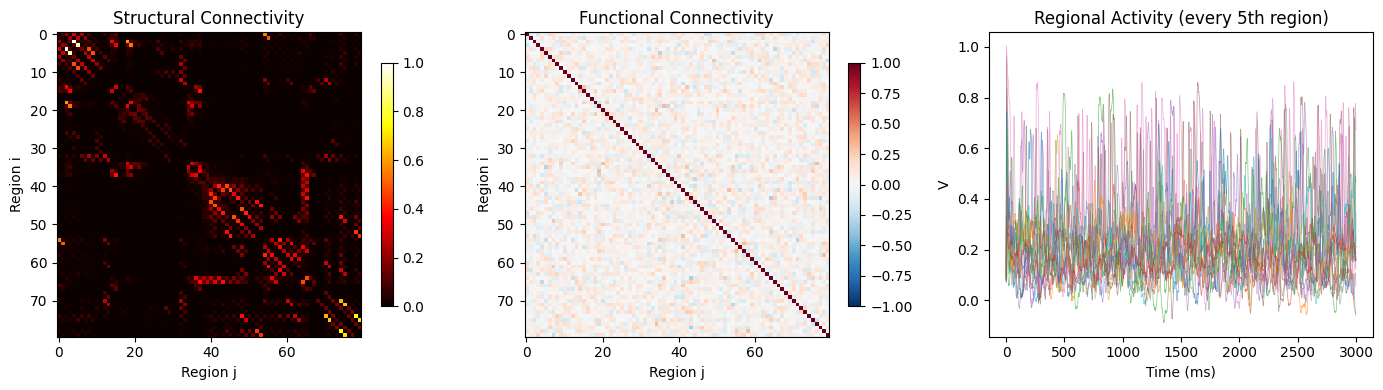

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Structural connectivity
im0 = axes[0].imshow(data['Cmat'], cmap='hot')
axes[0].set_title('Structural Connectivity')
axes[0].set_xlabel('Region j')
axes[0].set_ylabel('Region i')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

# Functional connectivity
fc = braintools.metric.functional_connectivity(V_network)
im1 = axes[1].imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1].set_title('Functional Connectivity')
axes[1].set_xlabel('Region j')
axes[1].set_ylabel('Region i')
plt.colorbar(im1, ax=axes[1], shrink=0.8)

# Time series
times = indices * dt
axes[2].plot(times[::10], V_network[::10, ::5], alpha=0.6, linewidth=0.5)
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('V')
axes[2].set_title('Regional Activity (every 5th region)')

plt.tight_layout()
plt.show()

## Exercises

### Exercise 1: Pulse Response

The excitable regime shows threshold behavior. Apply a brief pulse:

```python
def pulse_input(t):
    """Brief pulse at t=100ms"""
    return 0.5 if 100 < float(t/u.ms) < 105 else 0.0
```

Questions:
1. What pulse amplitude triggers an action potential?
2. How does the threshold depend on the baseline input?

### Exercise 2: Recovery Time Constant

Explore the effect of $\tau$:

```python
for tau_val in [10, 20, 50, 100]:
    model = brainmass.FitzHughNagumoStep(1, tau=tau_val * u.ms)
    # Simulate and observe...
```

How does $\tau$ affect:
1. Oscillation frequency?
2. Spike shape?

### Exercise 3: Structure-Function Relationship

Compare structural and functional connectivity:

```python
# Flatten matrices and compute correlation
sc = data['Cmat'].flatten()
fc_vals = fc.flatten()
correlation = np.corrcoef(sc, fc_vals)[0, 1]
```

How does coupling strength affect structure-function correlation?

## Summary

In this tutorial, you learned:

1. **FitzHugh-Nagumo equations**: A 2D reduction of Hodgkin-Huxley
2. **Excitability vs oscillation**: Input-dependent regime transitions
3. **Nullcline analysis**: Understanding fixed points and dynamics
4. **Brain networks**: Coupling FHN nodes with realistic connectivity

### Key Insights

- **Fast-slow dynamics**: V changes rapidly, w recovers slowly
- **Threshold behavior**: Excitable systems require sufficient perturbation
- **Bifurcation**: External input controls transition to oscillation

### Comparison with Van der Pol

| Feature | FitzHugh-Nagumo | Van der Pol |
|---------|-----------------|-------------|
| Origin | Hodgkin-Huxley reduction | Electrical oscillator |
| Regimes | Excitable + oscillatory | Always oscillatory |
| Neuroscience | Action potentials | Relaxation oscillations |


## References

1. FitzHugh, R. (1961). Impulses and physiological states in theoretical models of nerve membrane. *Biophysical Journal*, 1(6), 445-466.

2. Nagumo, J., Arimoto, S., & Yoshizawa, S. (1962). An active pulse transmission line simulating nerve axon. *Proceedings of the IRE*, 50(10), 2061-2070.

3. Izhikevich, E. M. (2007). *Dynamical Systems in Neuroscience*. MIT Press. (Chapter 4)